In [4]:
import numpy as np
import pandas as pd
import cmd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from IPython.display import clear_output
import matplotlib.pyplot as plt
import random
import itertools
%matplotlib inline

df = pd.read_csv('DataFrame.csv', sep = ';', index_col = 0)

DS_input = [1,2,3,4]
IF_input = [1,2,3]
TC_input = [0,1,2,3,4,5,6,7,8,9,10]
TS_input = [1,2,3,4,5,6]
ES_input = [1,2]
Pa_input = [0,1,2,3,4,'1,2','1,3','1,4','2,3','2,4','3,4','1,2,3','1,2,4','1,3,4','2,3,4','1,2,3,4']
count = 0
labels = np.concatenate((np.delete(df.columns.values, 0), df['Name'].unique()))
df_verification = pd.DataFrame(columns = labels)

for inputs in itertools.product(DS_input,IF_input,TC_input,TS_input,ES_input,Pa_input):

    #creates the base DFs to train regression model (with Product and Service)

    df_input = df.iloc[:,1:16]
    df_middle = df.iloc[:,16:]

    #creates the base DFs to train classification model (with Product and Service)

    added_to_second = ['DS Discover', 'DS Define','DS Develop','DS Deliver', 'ES Product', 'ES Service', 'Team size min',
                       'Part Users', 'Part Experts', 'Part Service staff', 'Part Stakeholders']
    df_middle_second = pd.concat([df_middle, df[added_to_second]], axis = 1)
    df_middle_second.iloc[:,:3] = df_middle_second.iloc[:,:3].apply(lambda x: x*2)

    mapping_names = {name: index for index, name in enumerate(sorted(df['Name'].unique()))}
    df_output = df['Name'].map(mapping_names)

    #user inputs
    def questionnaire(answer):
        var = answer
        if isinstance(var, str):
            var = [int(i) for i in var.split(sep = ',')]
        return var

    design_step = questionnaire(inputs[0])

    innovation_focus = questionnaire(inputs[1])

    team_cohesion = questionnaire(inputs[2])/10

    team_size = questionnaire(inputs[3])

    expected_solution = questionnaire(inputs[4])
    
    participants = questionnaire(inputs[5])
    if isinstance(participants, int):
        participants = [participants]
    
    #participants = [ans[0] for ans in participants]

    #inputs preparation
    indexes = df[df.iloc[:,design_step]==1.].index #duplicating entries with DS = 1.
    df_middle_second = pd.concat((df_middle_second,df_middle_second.iloc[indexes]), axis = 0)
    df_middle_second.reset_index(drop = True, inplace = True)

    df_output = pd.concat((df_output,df_output.iloc[indexes]), axis = 0)
    df_output.reset_index(drop = True, inplace = True)

    user_inputs = pd.DataFrame(0., index = ['Results'], columns = df.iloc[:,1:16].columns.values) #put user inputs in a DF

    user_inputs.iloc[:,design_step-1] = 1.

    if innovation_focus == 1:
        user_inputs.loc[:,['IF Incremental','IF Evolutive','IF Radical']] = [1,0,0]
    elif innovation_focus == 2:
        user_inputs.loc[:,['IF Incremental','IF Evolutive','IF Radical']] = [0,1,0]
    else:
        user_inputs.loc[:,['IF Incremental','IF Evolutive','IF Radical']] = [0,0,1]
    '''    
    if_incremental = -2.*innovation_focus+1.
    user_inputs.loc[:,'IF Incremental'] = if_incremental if if_incremental > 0. else 0.
    user_inputs.loc[:,'IF Evolutive'] = 1.-abs(2.*innovation_focus-1.)
    if_radical = 2.*innovation_focus-1.
    user_inputs.loc[:,'IF Radical'] = if_radical if if_radical > 0. else 0.
    '''
    user_inputs.loc[:,'Team cohesion'] = team_cohesion

    team_size = (team_size - 1.)/(6.-1.)
    user_inputs.loc[:,'Team size min'] = team_size if team_size <= 1 else 1.

    if expected_solution == 1:
        user_inputs.drop('ES Service', inplace = True, axis = 1)
        df_input.drop('ES Service', inplace = True, axis = 1)
        df_middle_second.drop('ES Service', inplace = True, axis = 1)
        added_to_second.remove('ES Service')
        user_inputs.loc[:,'ES Product'] = 1.
    else:
        user_inputs.drop('ES Product', inplace = True, axis = 1)
        df_input.drop('ES Product', inplace = True, axis = 1)
        df_middle_second.drop('ES Product', inplace = True, axis = 1)
        added_to_second.remove('ES Product')
        user_inputs.loc[:,'ES Service'] = 1.

    a = {1: 'Part Users', 2: 'Part Experts', 3: 'Part Service staff', 4: 'Part Stakeholders'}
    if participants != [0]:
        for part in participants:
            column = a[part]
            user_inputs.loc[:,column] = 1.

    #ML models
    #regression

    rgr = {}
    for feature in df_middle:
        X_rgr = df_input
        y_rgr = df_middle[feature]
        estimator = GradientBoostingRegressor(learning_rate = 0.4, n_estimators = 25, max_depth = 5)
        rgr.update({feature: estimator.fit(X_rgr,y_rgr)})

    #classification

    X_clf = df_middle_second
    y_clf = df_output

    clf = LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', C = 0.7)
    clf.fit(X_clf, y_clf)

    #predictions

    predict_first = pd.DataFrame(index = ['Results'], columns = df_middle.columns.values) #create DF to 1st prediction

    for feature in df_middle:
        predict_first.loc['Results',feature] = rgr[feature].predict(user_inputs)[0] #predict values for CITs characteristics

    predict_first = pd.concat([predict_first, user_inputs[added_to_second]], axis = 1) #add missing values from user inputs
    predict_first = predict_first.apply(pd.to_numeric, errors='coerce')

    predict_second = pd.DataFrame(index = ['Results'], columns = sorted(df['Name'].unique())) #create DF to 2nd prediction
    predict_second.loc[:,:] = clf.predict_proba(predict_first) #predict adequate CITs

    #predict_second[df['Name'][df.iloc[:,design_step]!=0].unique()] *= 1.25

    #results

    results = pd.DataFrame(index = ['Results'], columns = ['First', 'proba1', 'Second', 'proba2', 'Third', 'proba3'])

    best_three = predict_second.sort_values(by = ['Results'], axis = 1, ascending = False).iloc[:,:3]
    
    bag = []
    sort = predict_second.sort_values(by = ['Results'], axis = 1, ascending = False)
    for i, item in enumerate(sort.iloc[0,:-1]):
        if item == sort.iloc[0,i+1] and item != 0:
            bag.append(i)
            bag.append(i+1)
    
    if bag:
        if bag[0] == 2:
            draw = random.choice(list(set(bag)))
            best_three.drop(best_three.iloc[:,2].name, axis = 1, inplace = True)
            best_three[sort.iloc[:,draw].name] = sort.iloc[:,draw][0]

    results.loc[:,:] = [best_three.columns[0], best_three.iloc[0,0], best_three.columns[1], best_three.iloc[0,1],
                        best_three.columns[2], best_three.iloc[0,2]]

    for column in [5,3,1]:
        if results.iloc[:,column][0] < 0.001: #removes probas below tolerance
            results.drop([results.iloc[:,column-1].name, results.iloc[:,column].name], axis = 1, inplace = True)


    #finding the importance of each user input to the inference process
    feature_importances = [0]*df_input.shape[1]
    for key in rgr.keys():
        feature_importances+= rgr[key].feature_importances_
    feature_importances = pd.DataFrame(feature_importances.reshape(1,-1), index = [0], columns = df_input.columns.values)

    columns = ['Design step', 'Innovation focus', 'Team cohesion', 'Team size', 'Expected solution', 'Participants']

    DS = np.sum(feature_importances.loc[:,['DS Discover', 'DS Define', 'DS Develop', 'DS Deliver']], axis = 1)[0]
    IF = np.sum(feature_importances.loc[:,['IF Incremental', 'IF Evolutive', 'IF Radical']], axis = 1)[0]
    TC = np.sum(feature_importances.loc[:,['Team cohesion']], axis = 1)[0]
    TS = np.sum(feature_importances.loc[:,['Team size min']], axis = 1)[0]
    try:
        ES = np.sum(feature_importances.loc[:,['ES Product']], axis = 1)[0] 
    except:
        ES = np.sum(feature_importances.loc[:,['ES Service']], axis = 1)[0]
    Pa = np.sum(feature_importances.loc[:,['Part Users', 'Part Experts', 'Part Service staff', 'Part Stakeholders']], axis = 1)[0]

    factor_importances = np.array([DS*2, IF, TC, TS, ES, Pa])
    factor_importances = pd.DataFrame(factor_importances.reshape(1,-1), index = [0], columns = columns)
    sorted(factor_importances)
    
    df_verification.loc[count] = pd.concat((user_inputs.iloc[0,:],predict_first.drop(added_to_second, axis = 1).iloc[0,:],
                             predict_second.iloc[0,:]))
    df_verification.loc[count].fillna(0, inplace = True)
    print('\r {} / {}'.format(count, '25344'), end='')
    count += 1
    if count == 20:
        break

 19 / 25344

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_verification = pd.read_csv('Verification_DataFrame.csv', sep = ';', index_col = 0)

In [29]:
#number of CITs considered FIRST in all executions
firsts_list = list(df_verification.iloc[:,-21:].idxmax(axis=1).values)
{i:firsts_list.count(i) for i in fistst_list}

{'Mind Map': 1304,
 'Functional Analysis': 167,
 'Contextual Interview': 4916,
 'Traditional Brainstorming': 7588,
 'Impact Matrix': 2497,
 '5 Whys': 1167,
 'Dot Voting': 2557,
 'Stakeholder Map': 952,
 'How Might We': 233,
 'Shadowing': 495,
 'Persona': 47,
 'Affinity Diagram': 995,
 'Reverse Brainstorming': 1080,
 'Storyboard': 321,
 'Blueprint': 72,
 'Rough Prototyping': 779,
 'Brainwriting': 99,
 'Bio-inspiration': 3,
 'Pugh Matrix': 53,
 'Alpha Prototyping': 19}

In [381]:
#number of CITs part of the top 3 in all executions
name = df_verification.iloc[:,-21:].columns.values
all_list = []
for i, row in df_verification.iloc[:,-21:].iterrows():
    a=sorted(zip(row, name), reverse=True)[:3]
    if a[1][0] < 0.01:
        one_chosen = [x[1] for x in a[:1]]
        all_list.extend(one_chosen)
    elif a[2][0] < 0.01:
        two_chosen = [x[1] for x in a[:-1]]
        all_list.extend(two_chosen)
    else:
        three_chosen = [x[1] for x in a]
        all_list.extend(three_chosen)
all_list

['Mind Map',
 'Functional Analysis',
 'Traditional Brainstorming',
 'Functional Analysis',
 'Contextual Interview',
 'Mind Map',
 'Mind Map',
 'Functional Analysis',
 'Traditional Brainstorming',
 'Mind Map',
 'Functional Analysis',
 'Contextual Interview',
 'Mind Map',
 'Contextual Interview',
 'Functional Analysis',
 'Functional Analysis',
 'Traditional Brainstorming',
 'Contextual Interview',
 'Contextual Interview',
 'Functional Analysis',
 'Traditional Brainstorming',
 'Contextual Interview',
 'Mind Map',
 'Functional Analysis',
 'Functional Analysis',
 'Mind Map',
 'Traditional Brainstorming',
 'Mind Map',
 'Contextual Interview',
 'Functional Analysis',
 'Contextual Interview',
 'Mind Map',
 'Functional Analysis',
 'Contextual Interview',
 'Functional Analysis',
 'Traditional Brainstorming',
 'Contextual Interview',
 'Functional Analysis',
 'Mind Map',
 'Contextual Interview',
 'Functional Analysis',
 'Mind Map',
 'Contextual Interview',
 'Mind Map',
 'Functional Analysis',
 'Co

In [383]:
{i:all_list.count(i) for i in all_list}

{'Mind Map': 7409,
 'Functional Analysis': 690,
 'Traditional Brainstorming': 13666,
 'Contextual Interview': 11488,
 'Impact Matrix': 7625,
 'Stakeholder Map': 4452,
 '5 Whys': 6048,
 'Dot Voting': 6685,
 'Shadowing': 2360,
 'Reverse Brainstorming': 5417,
 'Affinity Diagram': 3579,
 'How Might We': 1087,
 'Rough Prototyping': 2100,
 'Persona': 202,
 'Brainwriting': 1242,
 'Storyboard': 989,
 'Blueprint': 411,
 'Morphological Analysis': 38,
 'Bio-inspiration': 28,
 'Alpha Prototyping': 126,
 'Pugh Matrix': 149}

In [403]:
#list of chosen CITs with probas
name = df_verification.iloc[:,-21:].columns.values
chosen = pd.DataFrame(columns = name)

for i, row in df_verification.iloc[:,-21:].iterrows():
    CIT_probas = pd.DataFrame(row).transpose().rename(index={i: 'Results'})
    best_three = CIT_probas.sort_values(by = ['Results'], axis = 1, ascending = False).iloc[:,:3]
    chosen = chosen.append(best_three.loc['Results'], ignore_index=True, sort = True)
chosen = chosen.mask(chosen < 0.01).fillna(0)

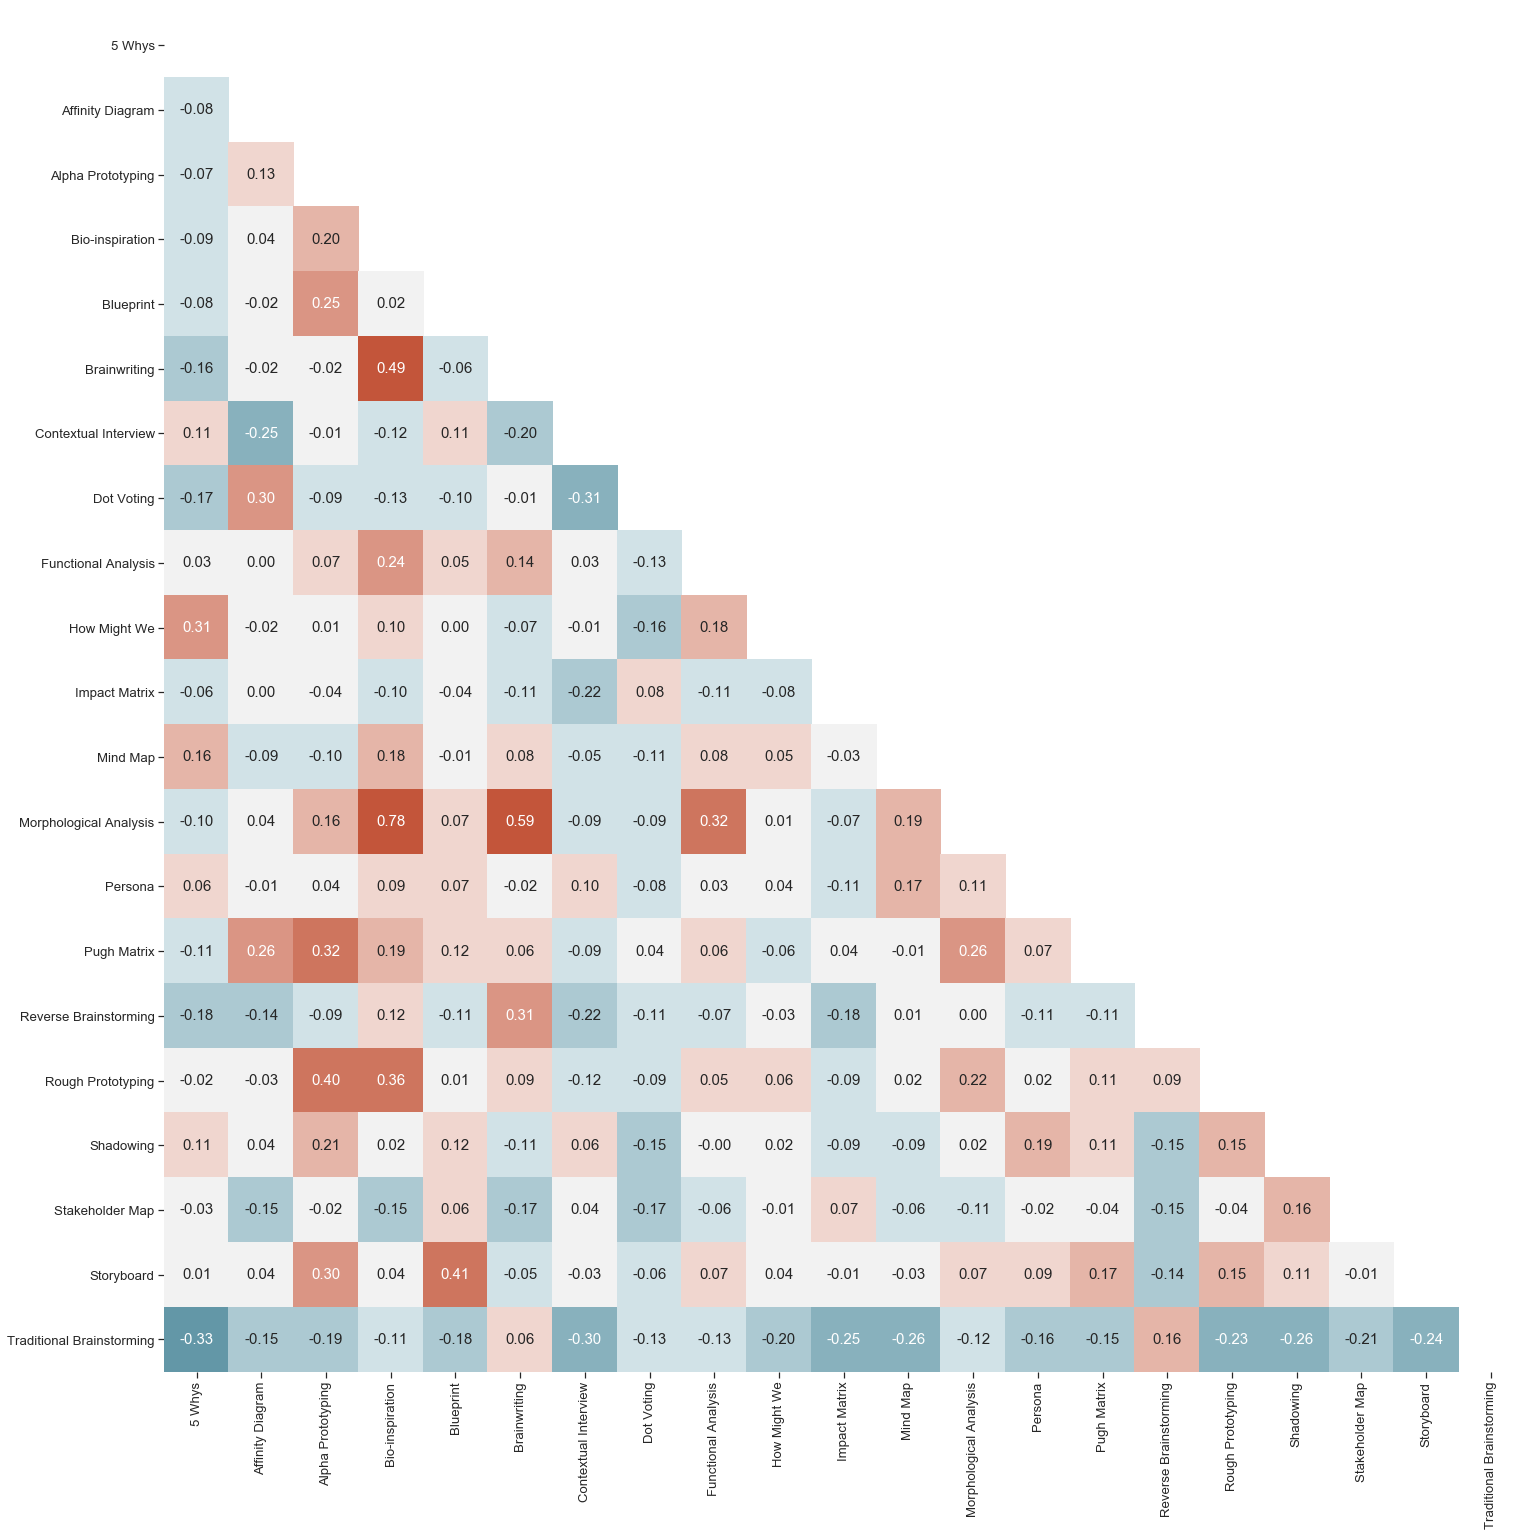

In [602]:
data_plot_2 = df_verification.iloc[:,-21:]
corr = data_plot_2.corr()
fig, ax = plt.subplots(figsize=(25,25))
plt.rcParams.update({'font.size': 15})
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns_plot = sns.heatmap(corr, mask=mask, center=0, annot=True, cbar=False, fmt = '.2f', square = True, vmin = -0.5, vmax = 0.5,
            cmap=sns.diverging_palette(220, 20, n=11))
plt.savefig('Images/heatmap_CITs.png', dpi = 300, bbox_inches  = 'tight')

In [406]:
#creates a df of cases with each of the 3 chosen CITs in a different line for categorization
all_chosen = pd.DataFrame(columns = df_verification.columns.values[:24])
all_chosen = all_chosen.append(df_verification.iloc[:,:24])
all_chosen = all_chosen.append(df_verification.iloc[:,:24])
all_chosen = all_chosen.append(df_verification.iloc[:,:24])
all_chosen.reset_index(drop = True, inplace = True)

list1 = chosen.T.apply(lambda x: x.nlargest(1).idxmin() if x.nlargest(3)[0] > 0.01 else 0)
list2 = chosen.T.apply(lambda x: x.nlargest(2).idxmin() if x.nlargest(3)[1] > 0.01 else 0)
list3 = chosen.T.apply(lambda x: x.nlargest(3).idxmin() if x.nlargest(3)[2] > 0.01 else 0)
list_full = pd.concat([list1,list2,list3], ignore_index = True)

all_chosen['CIT'] = list_full

all_chosen = all_chosen[all_chosen['CIT'] != 0]

list_ds = all_chosen.iloc[:,0:4].T.apply(lambda x: x.nlargest(1).idxmin())
all_chosen['Design Step'] = list_ds
DS_sort = {'DS Discover': 0, 'DS Define': 1, 'DS Develop': 2, 'DS Deliver': 3}
all_chosen['DS sort'] = all_chosen['Design Step'].map(DS_sort)

list_if = all_chosen.iloc[:,4:7].T.apply(lambda x: x.nlargest(1).idxmin())
all_chosen['Innovation Focus'] = list_if
IF_sort = {'IF Incremental': 0, 'IF Evolutive': 1, 'IF Radical': 2}
all_chosen['IF sort'] = all_chosen['Innovation Focus'].map(IF_sort)

list_es = all_chosen.iloc[:,9:11].T.apply(lambda x: x.nlargest(1).idxmin())
all_chosen['Expected Solution'] = list_es

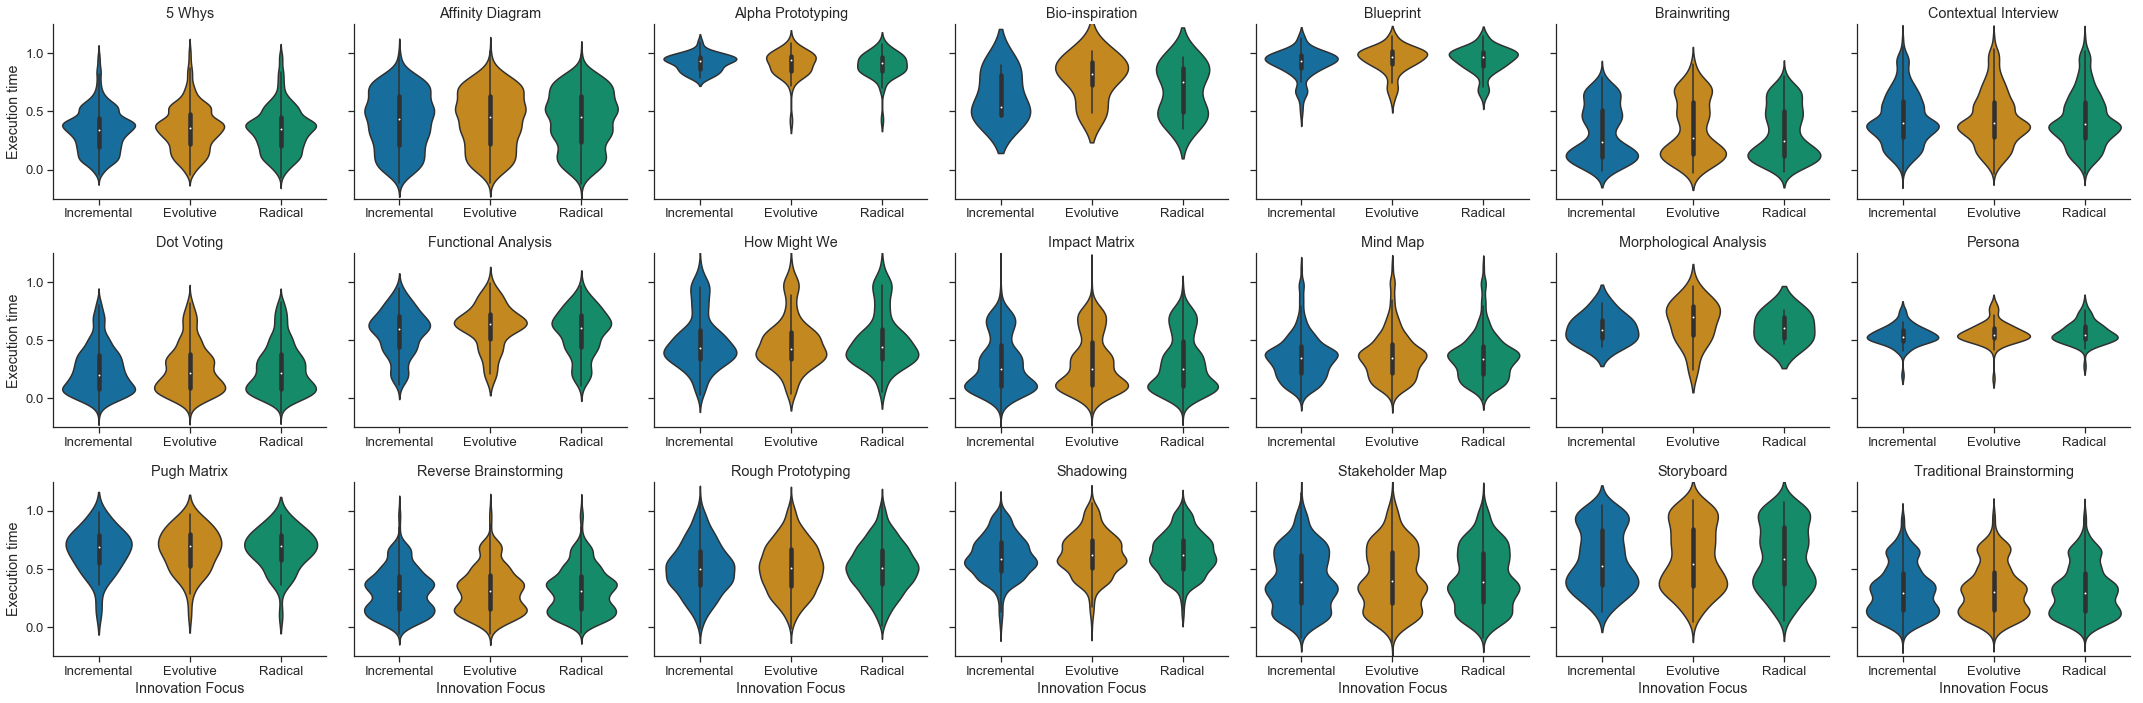

In [478]:
#generate integrated catplots for execution time vs design step/innovation focus per CIT
import seaborn as sns

#data = all_chosen.sort_values(['CIT','DS sort'])
data = all_chosen.sort_values(['CIT','IF sort'])

sns.set(font_scale=1.2)
sns.set_style("ticks")

g = sns.catplot(x="Innovation Focus", y="Execution time", data=data, palette = 'colorblind',
                kind="violin", col="CIT", col_wrap = 7, sharex = False)

g.set(ylim=[-.25,1.25], yticks=[0,0.5,1])

#g.set_xticklabels(["Discover", "Define", "Develop", "Deliver"]).set_titles("{col_name}")
g.set_xticklabels(["Incremental", "Evolutive", "Radical"]).set_titles("{col_name}")
g.fig.set_size_inches(30, 10)
g.fig.tight_layout()
sns.despine()

#g.savefig('Images/Catplot - DS - Execution Time.png', dpi = 300, bbox_inches = "tight")
g.savefig('Images/Catplot - IF - Execution Time.png', dpi = 300)

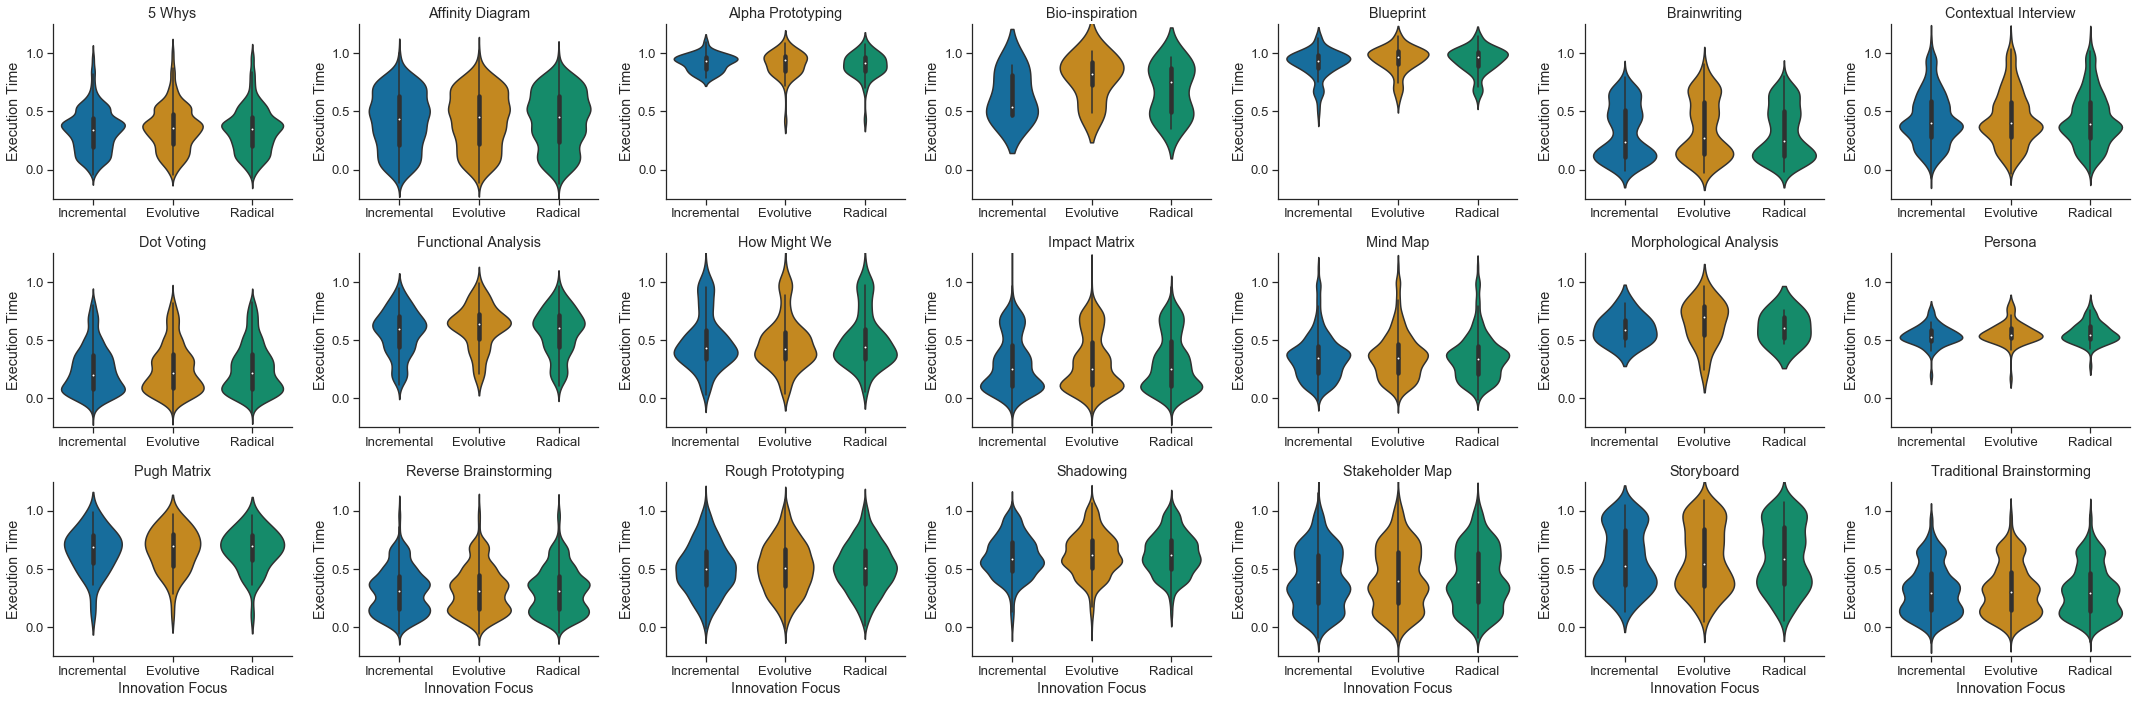

In [480]:
#generate individual catplots for execution time vs design step/innovation focus for each CIT

import seaborn as sns

#data = all_chosen.sort_values(['CIT','DS sort'])
data = all_chosen.sort_values(['CIT','IF sort'])

sns.set(font_scale=1.2)
sns.set_style("ticks")

g = sns.catplot(x="Innovation Focus", y="Execution time", data=data, palette = 'colorblind',
                kind="violin", col="CIT", col_wrap = 7, sharex = False, sharey = False)

for j in range(len(g.axes)):
    g.axes[j].yaxis.set_label_text('Execution Time')

g.set(ylim=[-.25,1.25], yticks=[0,0.5,1])

#g.set_xticklabels(["Discover", "Define", "Develop", "Deliver"]).set_titles("{col_name}")
g.set_xticklabels(["Incremental", "Evolutive", "Radical"]).set_titles("{col_name}")
g.fig.set_size_inches(30, 10)
g.fig.tight_layout()
sns.despine()

#g.savefig('Images/Catplot - DS - individual - Execution Time.png', dpi = 300, bbox_inches = "tight")
g.savefig('Images/Catplot - IF - individual - Execution Time.png', dpi = 300)

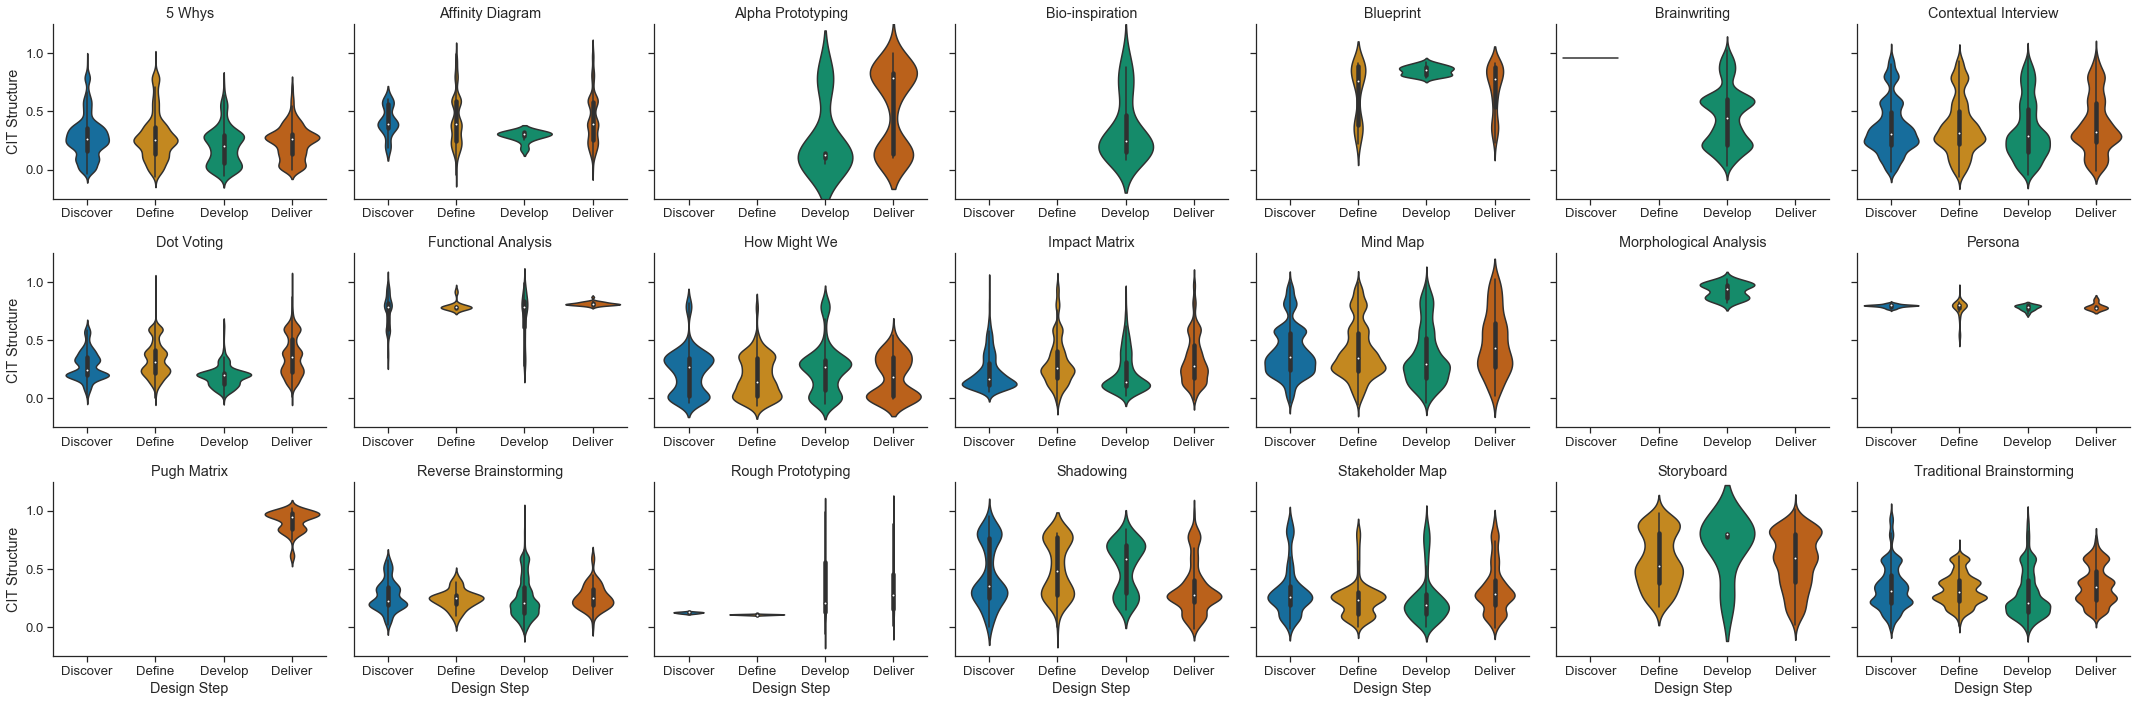

In [482]:
#generate integrated catplots for CIT Structure vs design step/innovation focus per CIT

import seaborn as sns

data = all_chosen.sort_values(['CIT','DS sort'])
#data = all_chosen.sort_values(['CIT','IF sort'])

sns.set(font_scale=1.2)
sns.set_style("ticks")

g = sns.catplot(x="Design Step", y="CIT Structure", data=data, palette = 'colorblind',
                kind="violin", col="CIT", col_wrap = 7, sharex = False)

g.set(ylim=[-.25,1.25], yticks=[0,0.5,1])

g.set_xticklabels(["Discover", "Define", "Develop", "Deliver"]).set_titles("{col_name}")
#g.set_xticklabels(["Incremental", "Evolutive", "Radical"]).set_titles("{col_name}")
g.fig.set_size_inches(30, 10)
g.fig.tight_layout()
sns.despine()

g.savefig('Images/Catplot - DS - CIT Structure.png', dpi = 300, bbox_inches = "tight")
#g.savefig('Images/Catplot - IF - CIT Structure.png', dpi = 300)

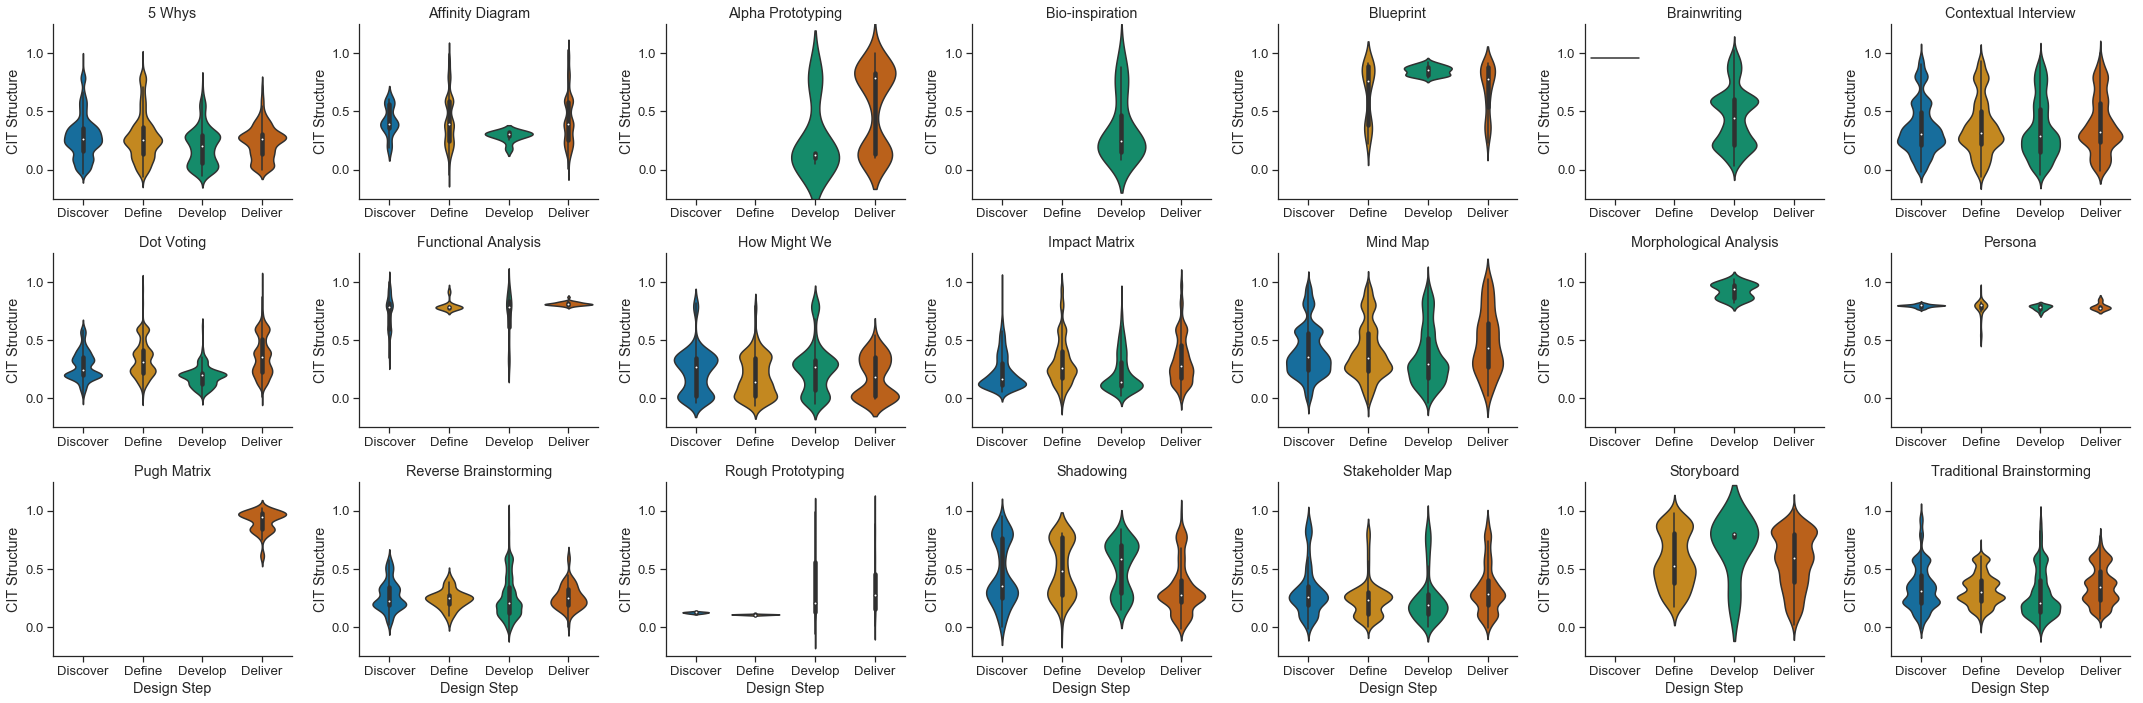

In [484]:
#generate individual catplots for CIT Structure vs design step/innovation focus for each CIT

import seaborn as sns

data = all_chosen.sort_values(['CIT','DS sort'])
#data = all_chosen.sort_values(['CIT','IF sort'])

sns.set(font_scale=1.2)
sns.set_style("ticks")

g = sns.catplot(x="Design Step", y="CIT Structure", data=data, palette = 'colorblind',
                kind="violin", col="CIT", col_wrap = 7, sharex = False, sharey = False)

for j in range(len(g.axes)):
    g.axes[j].yaxis.set_label_text('CIT Structure')

g.set(ylim=[-.25,1.25], yticks=[0,0.5,1])

g.set_xticklabels(["Discover", "Define", "Develop", "Deliver"]).set_titles("{col_name}")
#g.set_xticklabels(["Incremental", "Evolutive", "Radical"]).set_titles("{col_name}")
g.fig.set_size_inches(30, 10)
g.fig.tight_layout()
sns.despine()

g.savefig('Images/Catplot - DS - individual - CIT Structure.png', dpi = 300, bbox_inches = "tight")
#g.savefig('Images/Catplot - IF - individual - CIT Structure.png', dpi = 300)

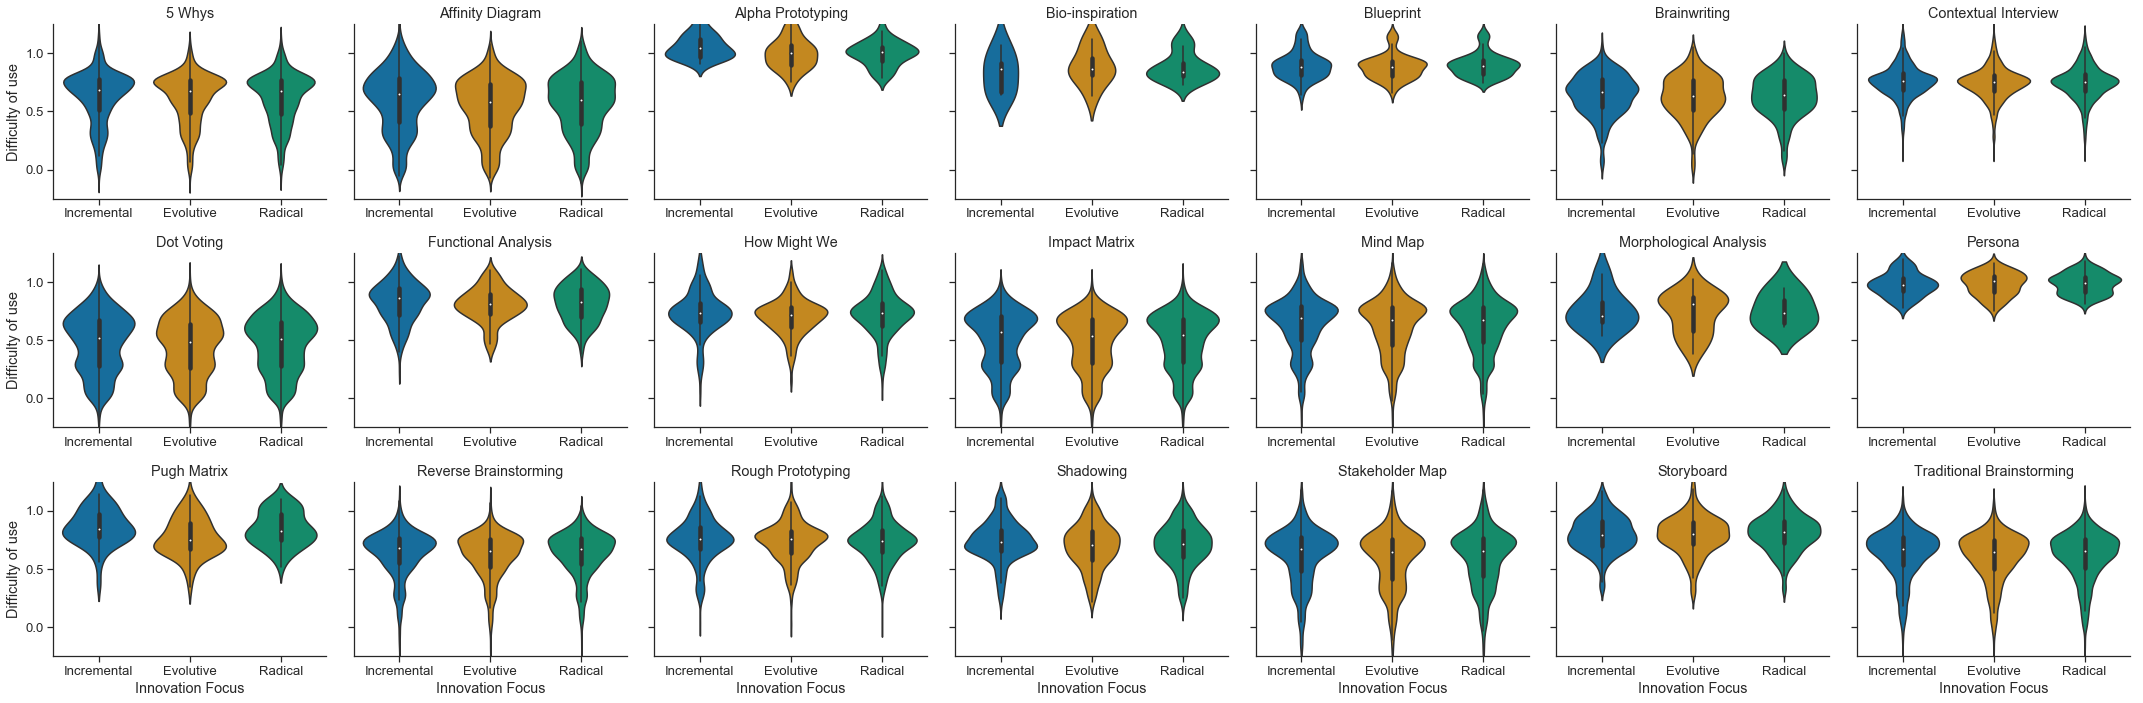

In [487]:
#generate integrated catplots for Difficulty of use vs design step/innovation focus per CIT

import seaborn as sns

#data = all_chosen.sort_values(['CIT','DS sort'])
data = all_chosen.sort_values(['CIT','IF sort'])

sns.set(font_scale=1.2)
sns.set_style("ticks")

g = sns.catplot(x="Innovation Focus", y="Difficulty of use", data=data, palette = 'colorblind',
                kind="violin", col="CIT", col_wrap = 7, sharex = False)

g.set(ylim=[-.25,1.25], yticks=[0,0.5,1])

#g.set_xticklabels(["Discover", "Define", "Develop", "Deliver"]).set_titles("{col_name}")
g.set_xticklabels(["Incremental", "Evolutive", "Radical"]).set_titles("{col_name}")
g.fig.set_size_inches(30, 10)
g.fig.tight_layout()
sns.despine()

#g.savefig('Images/Catplot - DS - Difficulty of use.png', dpi = 300, bbox_inches = "tight")
g.savefig('Images/Catplot - IF - Difficulty of use.png', dpi = 300)

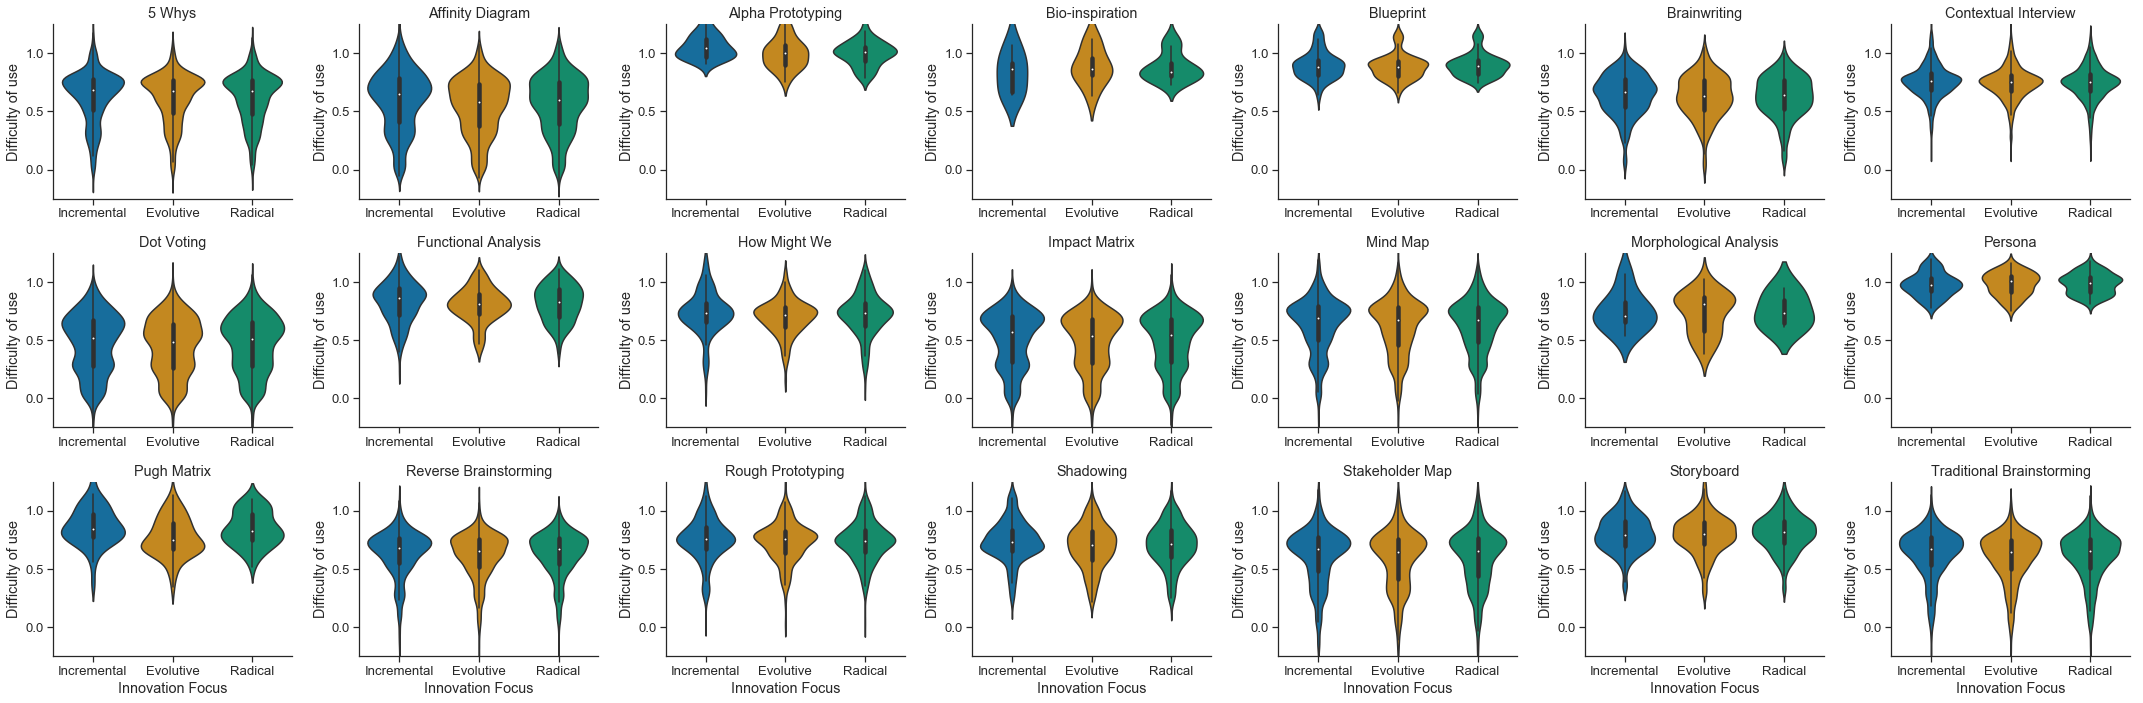

In [488]:
#generate individual catplots for Difficulty of use vs design step/innovation focus for each CIT

import seaborn as sns

#data = all_chosen.sort_values(['CIT','DS sort'])
data = all_chosen.sort_values(['CIT','IF sort'])

sns.set(font_scale=1.2)
sns.set_style("ticks")

g = sns.catplot(x="Innovation Focus", y="Difficulty of use", data=data, palette = 'colorblind',
                kind="violin", col="CIT", col_wrap = 7, sharex = False, sharey = False)

for j in range(len(g.axes)):
    g.axes[j].yaxis.set_label_text('Difficulty of use')

g.set(ylim=[-.25,1.25], yticks=[0,0.5,1])

#g.set_xticklabels(["Discover", "Define", "Develop", "Deliver"]).set_titles("{col_name}")
g.set_xticklabels(["Incremental", "Evolutive", "Radical"]).set_titles("{col_name}")
g.fig.set_size_inches(30, 10)
g.fig.tight_layout()
sns.despine()

#g.savefig('Images/Catplot - DS - individual - Difficulty of use.png', dpi = 300, bbox_inches = "tight")
g.savefig('Images/Catplot - IF - individual - Difficulty of use.png', dpi = 300)

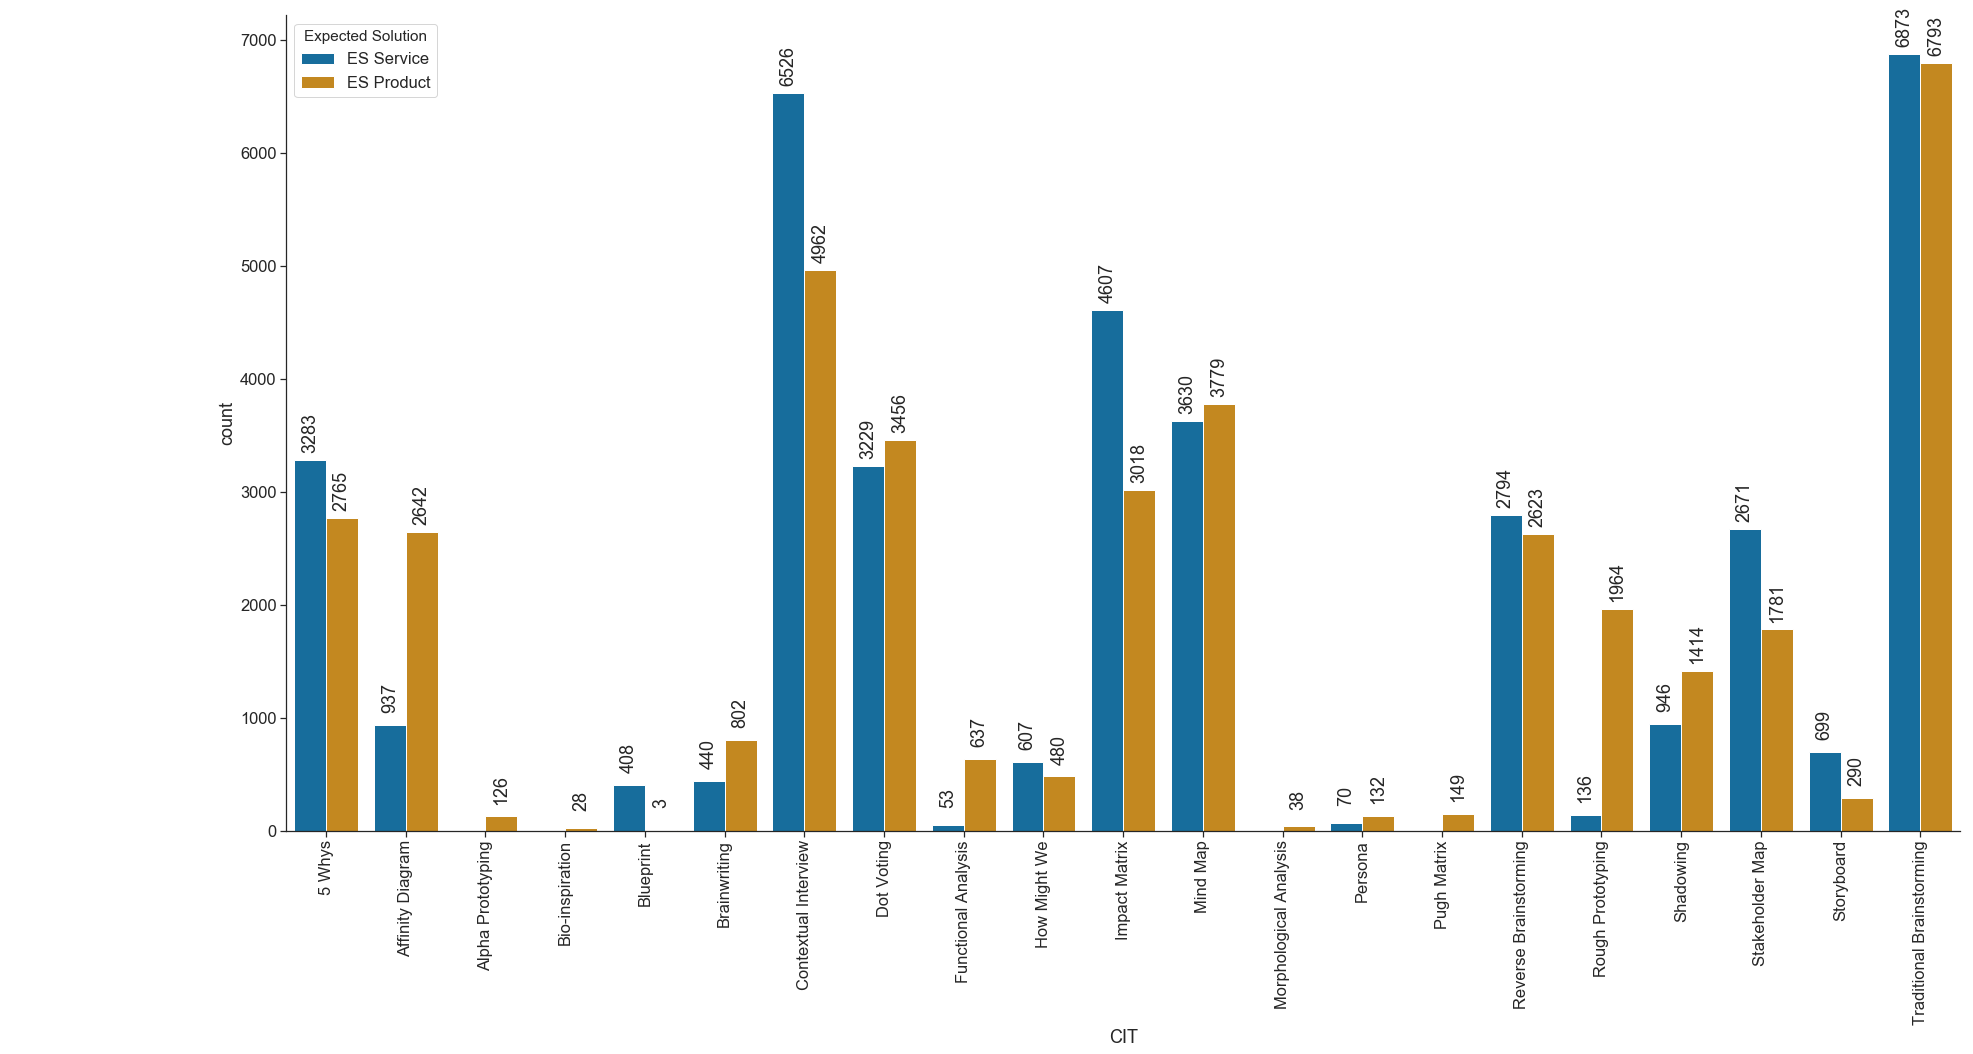

In [495]:
import seaborn as sns

data = all_chosen.sort_values(['CIT','DS sort'])
sns.set(font_scale=1.5)
sns.set_style("ticks")

plt.figure(figsize=(30,15))

g = sns.countplot(hue="Expected Solution", x = 'CIT', data=data, palette = 'colorblind')

g.set_xticklabels(labels = sorted(all_chosen['CIT'].unique()), rotation=90)

for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()+150),
               ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', rotation = 90)

sns.despine()

plt.savefig('Images/Countplot - Expected Solution.png', dpi = 300)

In [202]:
'''def participants_venn(row, list_part = []):
    if list(row[11:15]) == [0,0,0,0]:
        list_part.append([])
        
    if list(row[11:15]) == [1,0,0,0]:
        list_part.append(['User'])
    if list(row[11:15]) == [0,1,0,0]:
        list_part.append(['Experts'])
    if list(row[11:15]) == [0,0,1,0]:
        list_part.append(['Staff'])
    if list(row[11:15]) == [0,0,0,1]:
        list_part.append(['Stakeholders'])
        
    if list(row[11:15]) == [1,1,0,0]:
        list_part.append(['User','Experts'])
    if list(row[11:15]) == [1,0,1,0]:
        list_part.append(['User','Staff'])
    if list(row[11:15]) == [1,0,0,1]:
        list_part.append(['User','Stakeholders'])
    if list(row[11:15]) == [0,1,1,0]:
        list_part.append(['Experts','Staff'])
    if list(row[11:15]) == [0,1,0,1]:
        list_part.append(['Experts','Stakeholders'])
    if list(row[11:15]) == [0,0,1,1]:
        list_part.append(['Staff','Stakeholders'])
        
    if list(row[11:15]) == [1,1,1,0]:
        list_part.append(['User','Experts','Staff'])
    if list(row[11:15]) == [1,1,0,1]:
        list_part.append(['User','Experts','Stakeholders'])
    if list(row[11:15]) == [1,0,1,1]:
        list_part.append(['User','Staff','Stakeholders'])
    if list(row[11:15]) == [0,1,1,1]:
        list_part.append(['Experts','Staff','Stakeholders'])
        
    if list(row[11:15]) == [1,1,1,1]:
        list_part.append(['User','Experts','Staff','Stakeholders'])'''

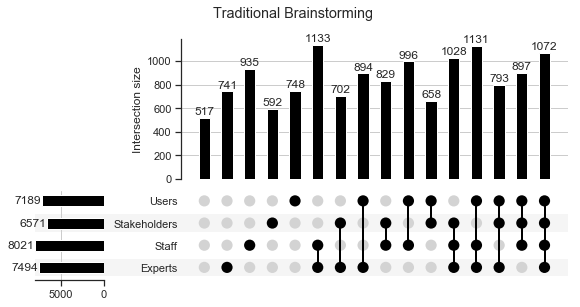

In [564]:
#upset plot for each CIT
import upsetplot
from upsetplot import plot, UpSet

CIT_name = 'Traditional Brainstorming'
sns.set(font_scale=1)
sns.set_style("ticks")
part_list = pd.DataFrame(all_chosen[all_chosen['CIT']=='5 Whys'].groupby(['Part Stakeholders', 'Part Service staff', 'Part Experts', 'Part Users']).count().iloc[:,0])
part_list = part_list.add(-part_list)
count_list = pd.DataFrame(all_chosen[all_chosen['CIT']==CIT_name].groupby(['Part Stakeholders', 'Part Service staff', 'Part Experts', 'Part Users']).count().iloc[:,0])
part_list = part_list.add(count_list)

list_part = [[], ['Users'], ['Experts'], ['Users', 'Experts'], ['Staff'], ['Users', 'Staff'], ['Experts', 'Staff'],
             ['Users', 'Experts', 'Staff'], ['Stakeholders'], ['Users', 'Stakeholders'], ['Experts', 'Stakeholders'], 
             ['Users', 'Experts', 'Stakeholders'], ['Staff', 'Stakeholders'], ['Users', 'Staff', 'Stakeholders'],
             ['Experts', 'Staff', 'Stakeholders'], ['Users', 'Experts', 'Staff', 'Stakeholders']]
values = part_list
data = upsetplot.from_memberships(list_part,data=values)
#plotting
upset = UpSet(data, show_counts = True, totals_plot_elements = 3, sort_categories_by = None, sum_over = 'DS Discover')
upset.plot()
plt.suptitle(CIT_name)
plt.savefig('Images/UpSetPlot - '+CIT_name+'.png', dpi = 300)
plt.show()

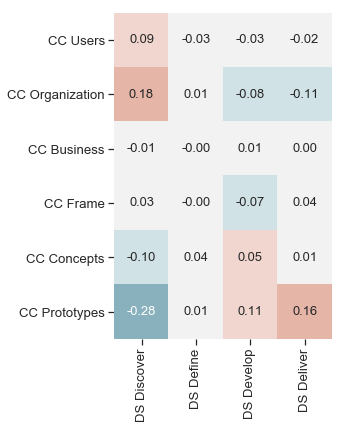

In [596]:
data_plot_3 = all_chosen.iloc[:,:24]
corr = data_plot_3.corr()
fig, ax = plt.subplots(figsize=(6,6))
plt.rcParams.update({'font.size': 13})
sns_plot = sns.heatmap(corr.iloc[-6:,:4], center=0, annot=True, cbar=False, fmt = '.2f', square = True, vmin = -0.5, vmax = 0.5,
            cmap=sns.diverging_palette(220, 20, n=11))
plt.yticks(rotation=0)
plt.savefig('Images/heatmap_Creative_Components.png', dpi = 300, bbox_inches  = 'tight')

In [609]:
chosen.iloc[:,10:]

,Impact Matrix,Mind Map,Morphological Analysis,Persona,Pugh Matrix,Reverse Brainstorming,Rough Prototyping,Shadowing,Stakeholder Map,Storyboard,Traditional Brainstorming
0,0.000000,0.649872,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.046881
1,0.000000,0.109452,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000
2,0.000000,0.389927,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.085914
3,0.000000,0.292814,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000
4,0.000000,0.349318,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.144642
6,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.130289
7,0.000000,0.158867,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000
8,0.000000,0.255667,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.154742
9,0.000000,0.313181,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000
